## FCN, Superficies de agua

In [1]:

from numpy import asarray
import numpy as np

import os
import cv2
import glob
import imagehash
from PIL import Image

import keras
import natsort
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout
from keras import optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, accuracy_score, f1_score



import matplotlib.pyplot as plt

from pickle import dump

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
images = sorted(glob.glob("ruta_imgs/*.jpg"))
masks = sorted(glob.glob("ruta_mascaras/*.jpg"))

print(len(images), len(masks))

2841 2841


**Análisis exploratorio de datos**

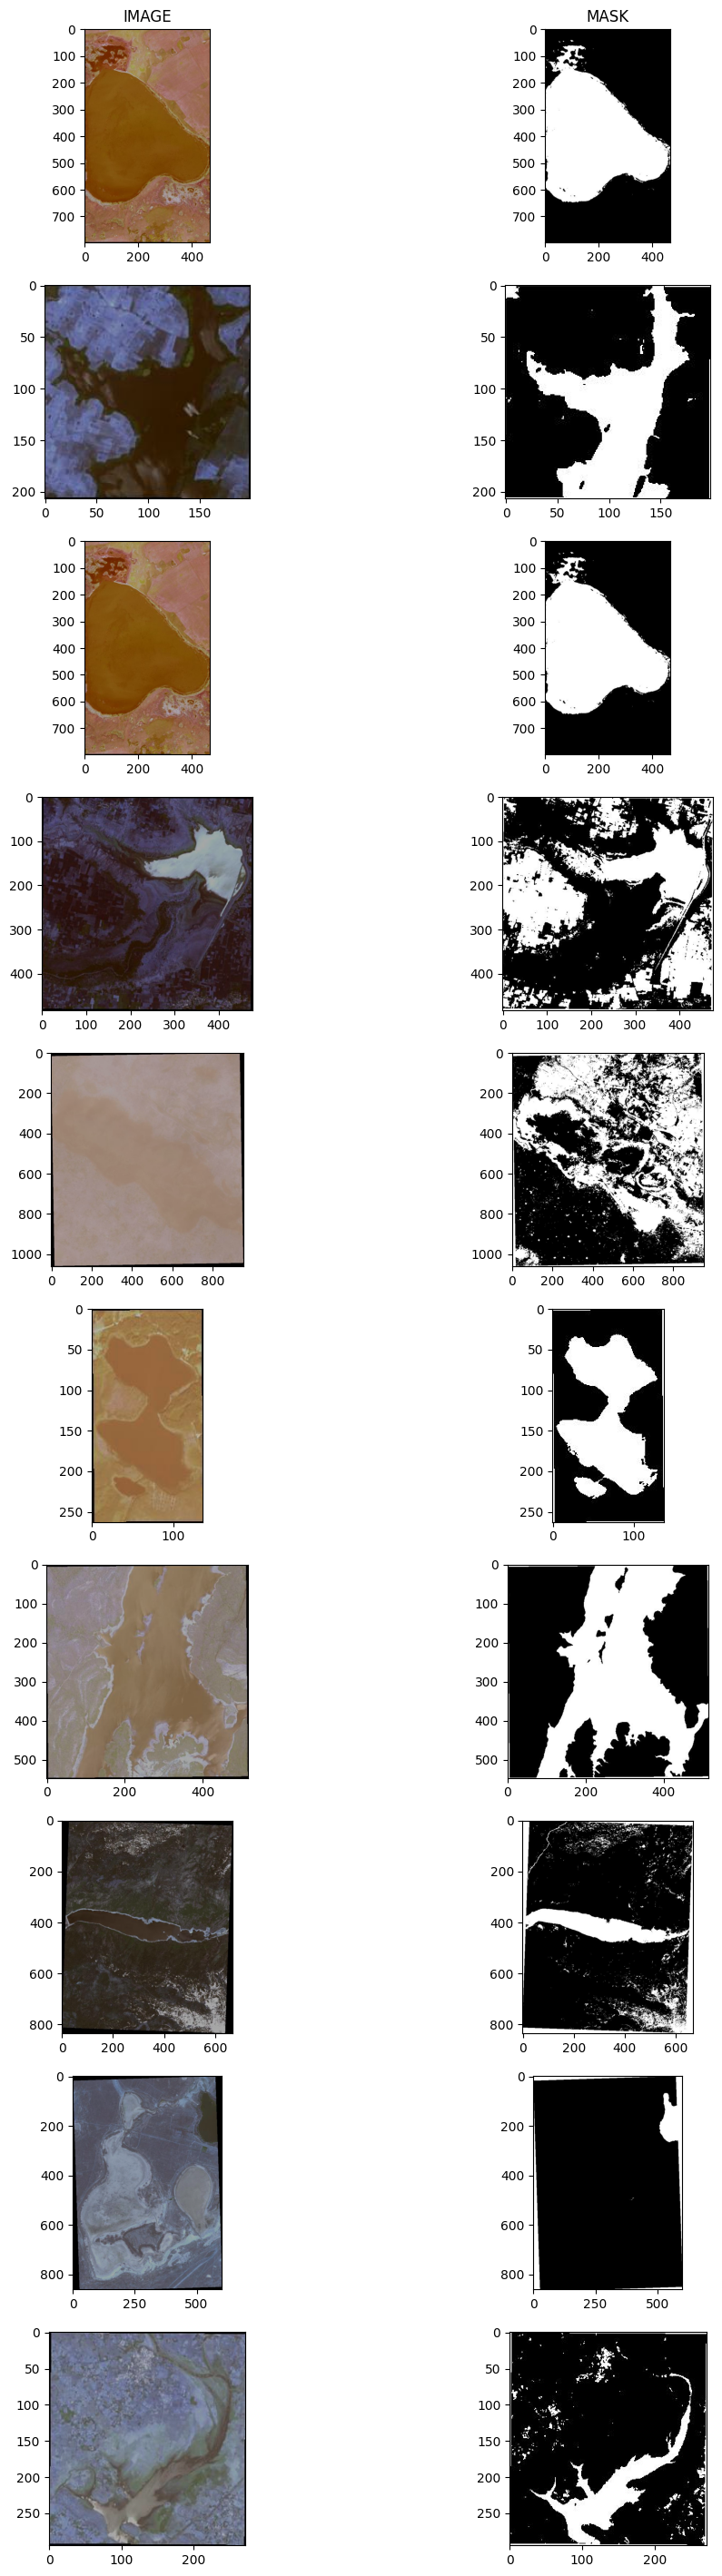

In [3]:
#visualización de imágenes
f, axr = plt.subplots(10,2, figsize=(12,36))
for i in range(10):
    idx = np.random.randint(0, len(images))
    original = cv2.imread(images[idx])
    mask = cv2.imread(masks[idx])
    axr[i,0].imshow(original)
    axr[i,1].imshow(mask)
    i +=1
    axr[0, 0].set_title("IMAGE")
    axr[0, 1].set_title("MASK")

In [4]:
# cálculos estadísticos de las dimensiones de las imágenes
dimen_img_list = []

for img in images:
    img = cv2.imread(img, cv2.COLOR_BGR2RGB)
    dimen_img = img.shape[:2]
    dimen_img_list.append(dimen_img)

dimen_img_array = np.array(dimen_img_list)   

In [5]:

print("Statistics of image dimensions:")
print("Minimum width:", np.min(dimen_img_array[:, 1]))
print("Maximum width:", np.max(dimen_img_array[:, 1]))
print("Mean width:", np.mean(dimen_img_array[:, 1]))
print("Median width:", np.median(dimen_img_array[:, 1]))
print("Standard deviation of width:", np.std(dimen_img_array[:, 1]))
print("Minimum height:", np.min(dimen_img_array[:, 0]))
print("Maximum height:", np.max(dimen_img_array[:, 0]))
print("Mean height:", np.mean(dimen_img_array[:, 0]))
print("Median height:", np.median(dimen_img_array[:, 0]))
print("Standard deviation of height:", np.std(dimen_img_array[:, 0]))

Statistics of image dimensions:
Minimum width: 5
Maximum width: 5640
Mean width: 445.2555438225977
Median width: 259.0
Standard deviation of width: 553.6202774845702
Minimum height: 7
Maximum height: 7093
Mean height: 560.6652587117212
Median height: 334.0
Standard deviation of height: 688.890393959364


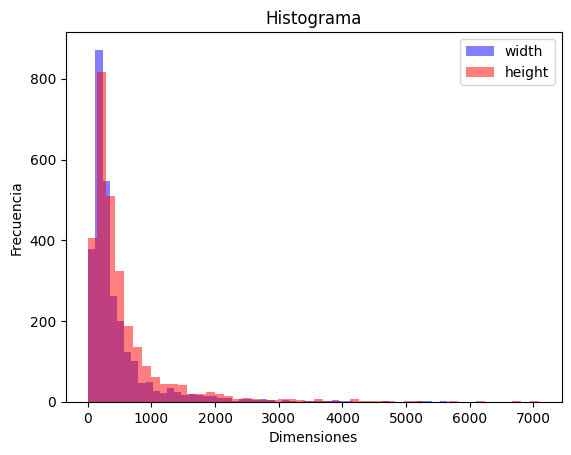

In [6]:
# Gráfico del histograma
plt.hist(dimen_img_array[:, 1], bins=50, alpha=0.5, color='blue', label='width')
plt.hist(dimen_img_array[:, 0], bins=50, alpha=0.5, color='red', label='height')
plt.xlabel('Dimensiones')
plt.ylabel('Frecuencia')
plt.title('Histograma')
plt.legend()
plt.show()

**Preparación de datos**

In [11]:
# a) Limpieza de datos

#detectar y remover duplicados
hashes = {}
to_remove = []

for file in images:
    if file.endswith('.jpg'):
        with open(file, 'rb') as f:
            img = Image.open(f)

            h = imagehash.phash(img)

            if h in hashes:
                print(f'Duplicate image found: {file} and {hashes[h]}')
                to_remove.append(file)
                mask_file = os.path.join("ruta_mascaras/*.jpg", os.path.basename(file))
                to_remove.append(mask_file)
            else:
                hashes[h] = file

Duplicate image found: /Users/sebastianandresvidalsalado/Desktop/Water Bodies/Water Bodies Dataset 2/Images/water_body_1244.jpg and /Users/sebastianandresvidalsalado/Desktop/Water Bodies/Water Bodies Dataset 2/Images/water_body_1023.jpg
Duplicate image found: /Users/sebastianandresvidalsalado/Desktop/Water Bodies/Water Bodies Dataset 2/Images/water_body_1333.jpg and /Users/sebastianandresvidalsalado/Desktop/Water Bodies/Water Bodies Dataset 2/Images/water_body_1023.jpg
Duplicate image found: /Users/sebastianandresvidalsalado/Desktop/Water Bodies/Water Bodies Dataset 2/Images/water_body_1552.jpg and /Users/sebastianandresvidalsalado/Desktop/Water Bodies/Water Bodies Dataset 2/Images/water_body_1023.jpg
Duplicate image found: /Users/sebastianandresvidalsalado/Desktop/Water Bodies/Water Bodies Dataset 2/Images/water_body_1619.jpg and /Users/sebastianandresvidalsalado/Desktop/Water Bodies/Water Bodies Dataset 2/Images/water_body_1023.jpg
Duplicate image found: /Users/sebastianandresvidalsa

In [15]:
# Creamos nueva lista con las imágenes y máscaras duplicadas excluídas
new_images = [file for file in images if file not in to_remove]
new_masks = [os.path.join("ruta_mascaras/", os.path.basename(file)) for file in new_images]
print(len(new_images), len(new_masks))

2824 2824


In [16]:
min_size = 32
df_images = []
df_masks = []

height = width = 512

for image, mask in zip(new_images, new_masks):
    n = cv2.imread(image, cv2.COLOR_BGR2RGB)
    m = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    
    if min(n.shape[:2]) > min_size and ((m != 0).any() and (m != 255).any()):
        n = cv2.resize(n, (height, width)) 
        df_images.append(n)
        m = cv2.resize(m, (height, width))
        df_masks.append(m)

df_images = asarray(df_images)

df_masks = asarray(df_masks)

print(len(df_images), len(df_masks))

2698 2698


In [17]:

X = df_images
y = df_masks

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1) #misma semilla en todos los modelos
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.015, random_state=1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(2023, 512, 512, 3) (2023, 512, 512) (664, 512, 512, 3) (664, 512, 512) (11, 512, 512, 3) (11, 512, 512)


In [18]:
# Flatten images and convert data from numpy array to float type
X_train = X_train.reshape(X_train.shape[0], height, width, 3).astype('float32')
X_test = X_test.reshape(X_test.shape[0], height, width, 3).astype('float32')
X_val = X_val.reshape(X_val.shape[0], height, width, 3).astype('float32')
y_train = y_train.reshape(y_train.shape[0], height, width).astype('float32')
y_test = y_test.reshape(y_test.shape[0], height, width).astype('float32')
y_val = y_val.reshape(y_val.shape[0], height, width).astype('float32')

In [19]:
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255
y_train = y_train / 255
y_test = y_test / 255
y_val = y_val / 255

In [20]:
print(X_train.shape, X_test.shape, X_val.shape)

(2023, 512, 512, 3) (664, 512, 512, 3) (11, 512, 512, 3)


**Evaluación de modelos**

Para realizar la segmentación de imágenes, un enfoque común es utilizar una arquitectura de Red Completamente Convolucional (FCN, por sus siglas en inglés), que consiste en capas convolucionales y capas de remuestreo para transformar la imagen de entrada en un mapa de segmentación.

Las capas de codificación suelen estar compuestas por capas de convolución y de pooling, que se utilizan para extraer características de alto nivel de la imagen de entrada mientras se reduce su resolución espacial. Las capas de convolución son responsables de detectar características locales como bordes, esquinas y regiones, mientras que las capas de pooling reducen la resolución espacial de los mapas de características para hacer la red más eficiente.

Las capas de decodificación, por otro lado, utilizan capas de remuestreo y capas convolucionales para transformar los mapas de características de baja resolución producidos por las capas de codificación en un mapa de segmentación de alta resolución. Las capas de remuestreo se utilizan para aumentar la resolución espacial de los mapas de características, mientras que las capas convolucionales refinan el mapa de segmentación y producen la salida final.

La arquitectura FCN combina las capas de codificación y decodificación para crear una red de segmentación de extremo a extremo que puede generar máscaras de segmentación a nivel de píxel para una imagen de entrada.

In [21]:
input_shape = (height, width, 3)

def base_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoding layers
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoding layers
    up3 = layers.UpSampling2D(size=(2, 2))(pool2)
    conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    conv4 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    outputs = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(up5)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build the model
model = base_model(input_shape)

y_train = y_train.reshape(-1, height, width, 1)
y_val = y_val.reshape(-1, height, width, 1)

In [22]:

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [23]:

history = model.fit(X_train, y_train, batch_size=64, epochs=30, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 722s 22s/step - accuracy: 0.5465 - loss: 0.6006 - val_accuracy: 0.7300 - val_loss: 0.4450
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 715s 22s/step - accuracy: 0.6391 - loss: 0.4856 - val_accuracy: 0.7401 - val_loss: 0.4225
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 732s 22s/step - accuracy: 0.6577 - loss: 0.4514 - val_accuracy: 0.7421 - val_loss: 0.3931
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 747s 23s/step - accuracy: 0.6681 - loss: 0.4328 - val_accuracy: 0.7344 - val_loss: 0.3607
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 762s 23s/step - accuracy: 0.6501 - loss: 0.4444 - val_accuracy: 0.7183 - val_loss: 0.3934
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 747s 23s/step - accuracy: 0.6731 - loss: 0.4186 - val_accuracy: 0.7529 - val_loss: 0.3165
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 785s 24s/step - accuracy: 0.6906 - loss: 0.3961 - val_accuracy: 0.7571 - val_loss: 0.3892
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 728s 22s/step - accuracy: 0.6694 - loss: 0.4298 - val_accuracy: 0.

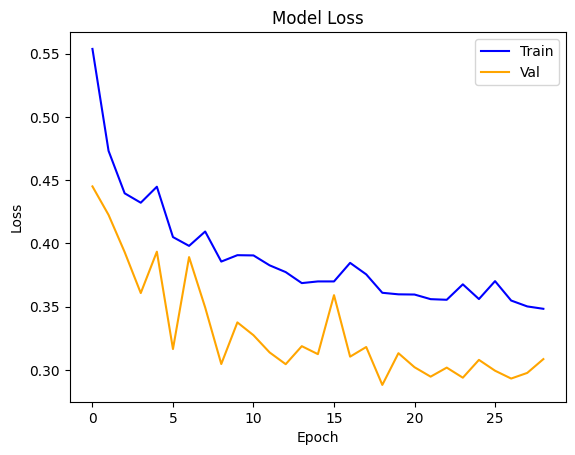

In [24]:
# Plot diagnostic learning curves
plt.title('Model Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"], loc ="upper right")

**Modelo base mejorado**

In [25]:
gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [26]:

train_gen = gen.flow(X_train, y_train, batch_size=64)
val_gen = gen.flow(X_val, y_val, batch_size=64)

In [27]:
# utilizamos la misma arquitectura base de FCN
model2 = base_model(input_shape)

In [28]:
# ajustamos el modelo
history2 = model2.fit(train_gen, epochs=30, batch_size=64, validation_data=val_gen, callbacks=[early_stopping])

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-23 09:42:15.555049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:200: Filling up shuffle buffer (this may take a while): 6 of 8
2024-10-23 09:42:19.221742: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 673s 20s/step - accuracy: 0.5504 - loss: 0.6225 - val_accuracy: 0.6242 - val_loss: 0.5704
Epoch 2/30


2024-10-23 09:53:28.018276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:200: Filling up shuffle buffer (this may take a while): 6 of 8
2024-10-23 09:53:31.689405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 678s 21s/step - accuracy: 0.5969 - loss: 0.5623 - val_accuracy: 0.7061 - val_loss: 0.5236
Epoch 3/30


2024-10-23 10:04:45.751695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:200: Filling up shuffle buffer (this may take a while): 6 of 8
2024-10-23 10:04:48.605264: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 702s 21s/step - accuracy: 0.6150 - loss: 0.5460 - val_accuracy: 0.6894 - val_loss: 0.5339
Epoch 4/30


2024-10-23 10:16:27.654146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:200: Filling up shuffle buffer (this may take a while): 6 of 8
2024-10-23 10:16:31.215301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 733s 22s/step - accuracy: 0.6129 - loss: 0.5484 - val_accuracy: 0.6940 - val_loss: 0.5212
Epoch 5/30


2024-10-23 10:28:39.490840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:200: Filling up shuffle buffer (this may take a while): 6 of 8
2024-10-23 10:28:43.081758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 720s 22s/step - accuracy: 0.6137 - loss: 0.5448 - val_accuracy: 0.6901 - val_loss: 0.5355
Epoch 6/30


2024-10-23 10:40:39.931589: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:200: Filling up shuffle buffer (this may take a while): 6 of 8
2024-10-23 10:40:43.500043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 717s 22s/step - accuracy: 0.6257 - loss: 0.5375 - val_accuracy: 0.7253 - val_loss: 0.5055
Epoch 7/30


2024-10-23 10:52:36.825519: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:200: Filling up shuffle buffer (this may take a while): 6 of 8
2024-10-23 10:52:40.534615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 743s 23s/step - accuracy: 0.6179 - loss: 0.5421 - val_accuracy: 0.7036 - val_loss: 0.5088
Epoch 8/30


2024-10-23 11:05:00.365425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:200: Filling up shuffle buffer (this may take a while): 6 of 8
2024-10-23 11:05:03.983418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 704s 21s/step - accuracy: 0.6249 - loss: 0.5352 - val_accuracy: 0.7198 - val_loss: 0.5028
Epoch 9/30


2024-10-23 11:16:44.338046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:200: Filling up shuffle buffer (this may take a while): 6 of 8
2024-10-23 11:16:48.013148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 702s 21s/step - accuracy: 0.6210 - loss: 0.5385 - val_accuracy: 0.6974 - val_loss: 0.5048
Epoch 10/30


2024-10-23 11:28:26.449036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:200: Filling up shuffle buffer (this may take a while): 6 of 8
2024-10-23 11:28:30.049926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 704s 21s/step - accuracy: 0.6258 - loss: 0.5326 - val_accuracy: 0.6796 - val_loss: 0.5389


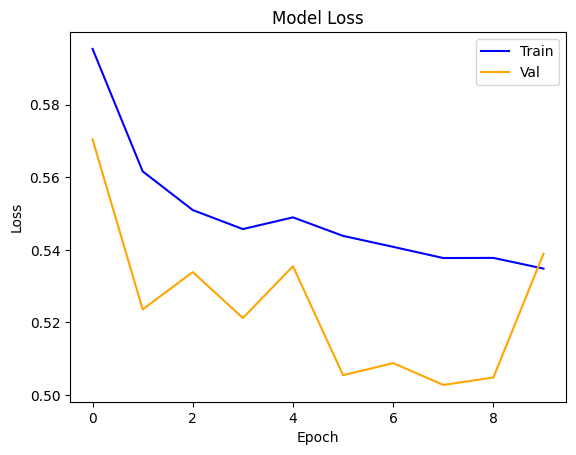

In [29]:

plt.title('Model Loss')
plt.plot(history2.history['loss'], color='blue', label='train')
plt.plot(history2.history['val_loss'], color='orange', label='test')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Val"], loc ="upper right")

**Finalización del modelo**

In [30]:
#guardamos el modelo
filename = 'finalized_model_FCN.sav'
dump(model, open(filename, 'wb'))

**Imágenes transformadas**

In [36]:
path_img_boxcox = 'ruta_imagenes_transformadas'

image_files = os.listdir(path_img_boxcox)

image_files = natsort.natsorted(image_files)

X_test_transform = []
for file_name in image_files:
    image_path = os.path.join(path_img_boxcox, file_name)
    image = cv2.imread(image_path)
    if image is not None:
        # Redimensionar la imagen a 512x512
        image_resized = cv2.resize(image, (512, 512))
        X_test_transform.append(image_resized)
        
X_test_transform = np.array(X_test_transform)

In [37]:
Pred_test_transform = model.predict(X_test_transform)

21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step


In [38]:
y_test_bin = (y_test > 0.5).astype(np.uint8)

Pred_test_bin = (Pred_test_transform > 0.5).astype(np.uint8)

y_test_flat = y_test_bin.ravel()
Pred_test_flat = Pred_test_bin.ravel()

iou = jaccard_score(y_test_flat, Pred_test_flat, average='macro')

dice = f1_score(y_test_flat, Pred_test_flat, average='macro')

accuracy = accuracy_score(y_test_flat, Pred_test_flat)

print(f"IoU promedio: {iou}")
print(f"Dice coefficient promedio: {dice}")
print(f"Accuracy promedio: {accuracy}")

IoU promedio: 0.3626046972717526
Dice coefficient promedio: 0.492076272114746
Accuracy promedio: 0.6112634992024985


**Imágenes no transformadas**

In [40]:
folder_path = 'ruta_imagenes_no_transformadasw'

image_files = os.listdir(folder_path)

image_files = natsort.natsorted(image_files)

X_test_l = []
for file_name in image_files:
    image_path = os.path.join(folder_path, file_name)
    image = cv2.imread(image_path)
    if image is not None:
        image_resized = cv2.resize(image, (512, 512))
        X_test_l.append(image_resized)

X_test_l = np.array(X_test_l)

In [41]:
Pred_test_l = model.predict(X_test_l)

21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step


In [42]:
y_test_bin = (y_test > 0.5).astype(np.uint8)

Pred_test_bin = (Pred_test_l > 0.5).astype(np.uint8)

y_test_flat = y_test_bin.ravel()
Pred_test_flat = Pred_test_bin.ravel()

iou = jaccard_score(y_test_flat, Pred_test_flat, average='macro')

dice = f1_score(y_test_flat, Pred_test_flat, average='macro')

accuracy = accuracy_score(y_test_flat, Pred_test_flat)

print(f"IoU promedio: {iou}")
print(f"Dice coefficient promedio: {dice}")
print(f"Accuracy promedio: {accuracy}")

IoU promedio: 0.4460734942295891
Dice coefficient promedio: 0.5801351854089845
Accuracy promedio: 0.7046137085880142


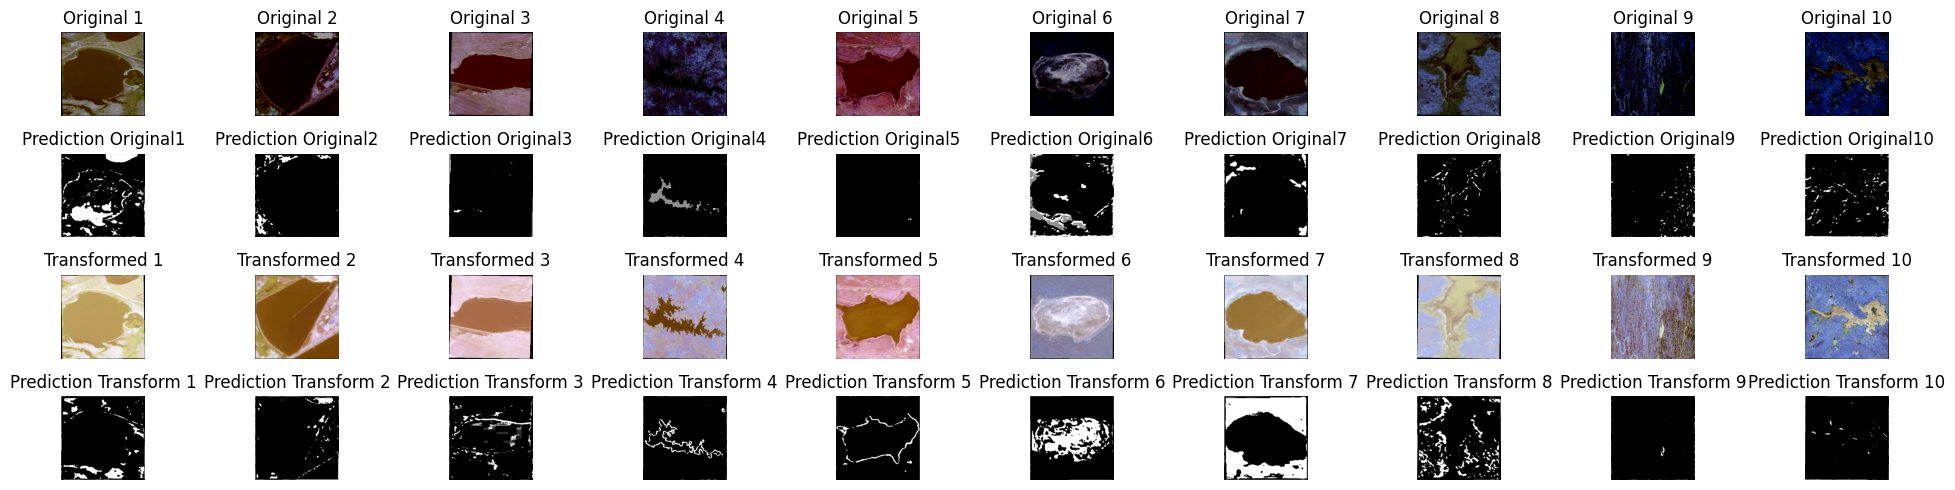

In [43]:
fig, axes = plt.subplots(4, 10, figsize=(20, 5))

for i in range(10):
    axes[0, i].imshow(X_test_l[i], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Original {i+1}")
    
    axes[1, i].imshow(Pred_test_l[i], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Prediction Original{i+1}")

    axes[2, i].imshow(X_test_transform[i], cmap='gray')
    axes[2, i].axis('off')
    axes[2, i].set_title(f"Transformed {i+1}")

    axes[3, i].imshow(Pred_test_transform[i], cmap='gray')
    axes[3, i].axis('off')
    axes[3, i].set_title(f"Prediction Transform {i+1}")

    
plt.tight_layout()
plt.show()